# Comparison between empirical and predicted pipeline similarities

In [31]:
import pickle
import fastdtw
import Levenshtein
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from matplotlib import pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MultiLabelBinarizer

wd = "D:/Meteor/Projects/RLproject/Guardian/Scripts" ###Change the path to the directory where the GCN-pipelines folder is located
#wd = "/gss/work/zead9360/"

file_paths = [f"{wd}/GCN-pipelines/multiverse/multiverse_pipelines/results/universe_{i}.pkl" for i in range(1, 15)] 
gcn_data = f"{wd}/GCN-pipelines/Data/graph_and_embeddings.pkl" 
pipeline_path = f"{wd}/GCN-pipelines/Data/pipelines_multiverse.xlsx"

The empirical similarity is estimated for 14 different pipelines as defined in the multiverse analysis in `mverse.py`:

In [32]:
universes_data = []
for file_path in file_paths:
    with open(file_path, 'rb') as file:
        universe = pickle.load(file)
        universes_data.append(list(universe.values()))

empirical_similarity = np.corrcoef(np.array(universes_data))

Data from the trained GCN network is loaded:

In [33]:
with open(gcn_data, 'rb') as file:
    loaded_variables = pickle.load(file)

G = loaded_variables["G"]
G_nx = loaded_variables["G_nx"]
nodes = loaded_variables["nodes"]
node_features = loaded_variables["node_features"]
embeddings = loaded_variables["embeddings"]

# Load pipelines and trained embeddings
pipeline_df = pd.read_excel(pipeline_path, index_col=0)
pipelines = pipeline_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
embeddings_dict = {label: emb for label, emb in zip(nodes, embeddings)}

Estimated pipeline dissimilarity from GCN predictions with DTW:

In [34]:
def dtw_reduce(data):
    num_features, _ = data.shape
    reference_sequence = np.mean(data, axis=0)  # Use mean sequence as reference
    dtw_distances = np.zeros(num_features)

    for i in range(num_features):
        distance, _ = fastdtw.fastdtw(data[i], reference_sequence)
        dtw_distances[i] = distance

    return dtw_distances

# Joint embeddings with dynamic time warping
pipeline_embeddings_dtw = []
for pipeline in pipelines:
        pipeline_embs = [embeddings_dict[node] for node in pipeline if node in embeddings_dict]
        if pipeline_embs:
            pipeline_embs = np.array(pipeline_embs)
            pipeline_embs = np.transpose(pipeline_embs)
            joint_embedding = dtw_reduce(pipeline_embs)
            pipeline_embeddings_dtw.append(joint_embedding)

joint_embeddings_dtw = pd.DataFrame(pipeline_embeddings_dtw)

dissimilarity_matrix = squareform(pdist(joint_embeddings_dtw, metric='euclidean'))
min_val = np.min(dissimilarity_matrix)
max_val = np.max(dissimilarity_matrix)
scaled_dissimilarity_matrix = (dissimilarity_matrix - min_val) / (max_val - min_val)
embedding_similarity_dtw = 1 - scaled_dissimilarity_matrix

In [35]:
print(pipelines)

[['Software', 'S-Skull_stripping', 'S-BBR_crossmodal_registration', 'S-INU_correction', 'S-Gradient_Distortion_Correction', 'F-Alignment/Head_motion_est', 'F-Field_map_correction', 'F-Unwarp', 'F-Coregistration', 'F-Spatial_normalization', 'F-Intensity_normalization', 'F-surface', 'Atlas_definition', 'ROI_definition', 'F-Temporal_filt', 'Compute_connectivity', 'Connectivity_normalization', 'Graph_characteristics', 'Sparsity_control', 'Graph_measures'], ['Software', 'S-Skull_stripping', 'S-BBR_crossmodal_registration', 'S-INU_correction', 'S-Gradient_Distortion_Correction', 'F-Alignment/Head_motion_est', 'F-Field_map_correction', 'F-Unwarp', 'F-Coregistration', 'F-Spatial_normalization', 'F-Intensity_normalization', 'F-surface', 'Atlas_definition', 'ROI_definition', 'Compute_connectivity', 'Connectivity_normalization', 'Graph_characteristics', 'Sparsity_control', 'Graph_measures'], ['Software', 'S-Skull_stripping', 'S-BBR_crossmodal_registration', 'S-INU_correction', 'S-Gradient_Distort

Other measures:

In [36]:
# Levenshtein distance
n = len(pipelines)
levenshtein_distance = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if i != j:
            levenshtein_distance[i, j] = Levenshtein.distance(pipelines[i], pipelines[j])

min_val = np.min(levenshtein_distance)
max_val = np.max(levenshtein_distance)
scaled_levenshtein_distance = (levenshtein_distance - min_val) / (max_val - min_val)
levenshtein_similarity = 1 - scaled_levenshtein_distance

# Hamming distance
n = len(pipelines)
hamming_distance = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if i != j:
            hamming_distance[i, j] = Levenshtein.hamming(pipelines[i], pipelines[j])

min_val = np.min(hamming_distance)
max_val = np.max(hamming_distance)
scaled_hamming_distance = (hamming_distance - min_val) / (max_val - min_val)
hamming_similarity = 1 - scaled_hamming_distance

# Jaccard distance
mlb = MultiLabelBinarizer()
pipeline_binary = mlb.fit_transform(pipelines)
jaccard_similarity = 1 - pairwise_distances(pipeline_binary, metric="jaccard")

d:\Meteor\Projects\RLproject\envs\DGI\lib\site-packages\sklearn\metrics\pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Plotting of pairwise similarity and correlation between emprical and predicted:

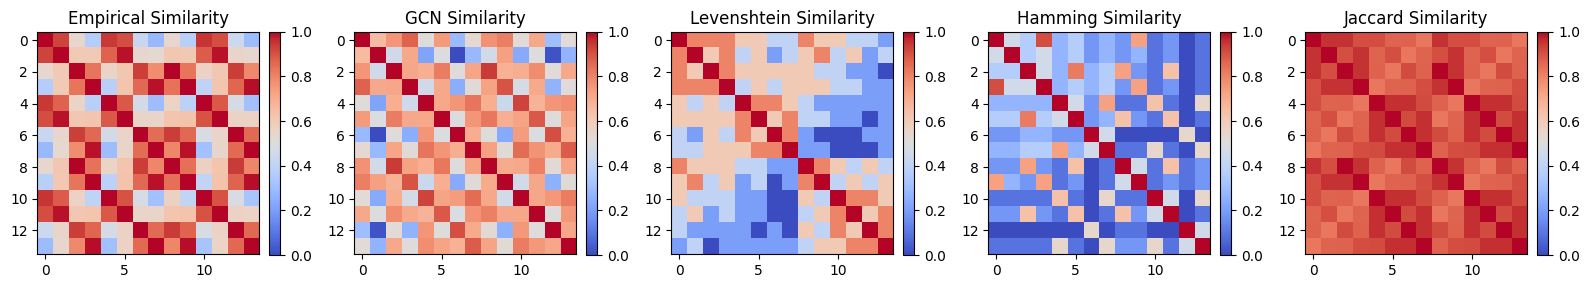

In [37]:
fig, ax = plt.subplots(1, 5, figsize=(16, 4))

vmin = 0
vmax = 1

im0 = ax[0].imshow(empirical_similarity, cmap='coolwarm', vmin=vmin, vmax=vmax)
ax[0].set_title('Empirical Similarity')
cbar0 = fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)  # Adjust colorbar height

im1 = ax[1].imshow(embedding_similarity_dtw, cmap='coolwarm', vmin=vmin, vmax=vmax)
ax[1].set_title('GCN Similarity')
cbar1 = fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

im2 = ax[2].imshow(levenshtein_similarity, cmap='coolwarm', vmin=vmin, vmax=vmax)
ax[2].set_title('Levenshtein Similarity')
cbar2 = fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

im3 = ax[3].imshow(hamming_similarity, cmap='coolwarm', vmin=vmin, vmax=vmax)
ax[3].set_title('Hamming Similarity')
cbar3 = fig.colorbar(im3, ax=ax[3], fraction=0.046, pad=0.04)

im4 = ax[4].imshow(jaccard_similarity, cmap='coolwarm', vmin=vmin, vmax=vmax)
ax[4].set_title('Jaccard Similarity')
cbar4 = fig.colorbar(im4, ax=ax[4], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# empirical_upper = empirical_similarity[np.triu_indices_from(empirical_similarity, k=1)]
# gcn_upper = embedding_similarity_dtw[np.triu_indices_from(embedding_similarity_dtw, k=1)]
# levenshtein_upper = levenshtein_similarity[np.triu_indices_from(levenshtein_similarity, k=1)]
# hamming_upper = hamming_similarity[np.triu_indices_from(hamming_similarity, k=1)]
# jaccard_upper = jaccard_similarity[np.triu_indices_from(jaccard_similarity, k=1)]

# similarity_data = pd.DataFrame({
#     'Empirical': empirical_upper,
#     'GCN': gcn_upper,
#     'Levenshtein': levenshtein_upper,
#     'Hamming': hamming_upper,
#     'Jaccard': jaccard_upper
# })

# spearman_corr = spearmanr(similarity_data)[0]
# print("Spearman correlation:\n", spearman_corr)


Compute the absolute error between each of the similarity measure and the empirical similarity

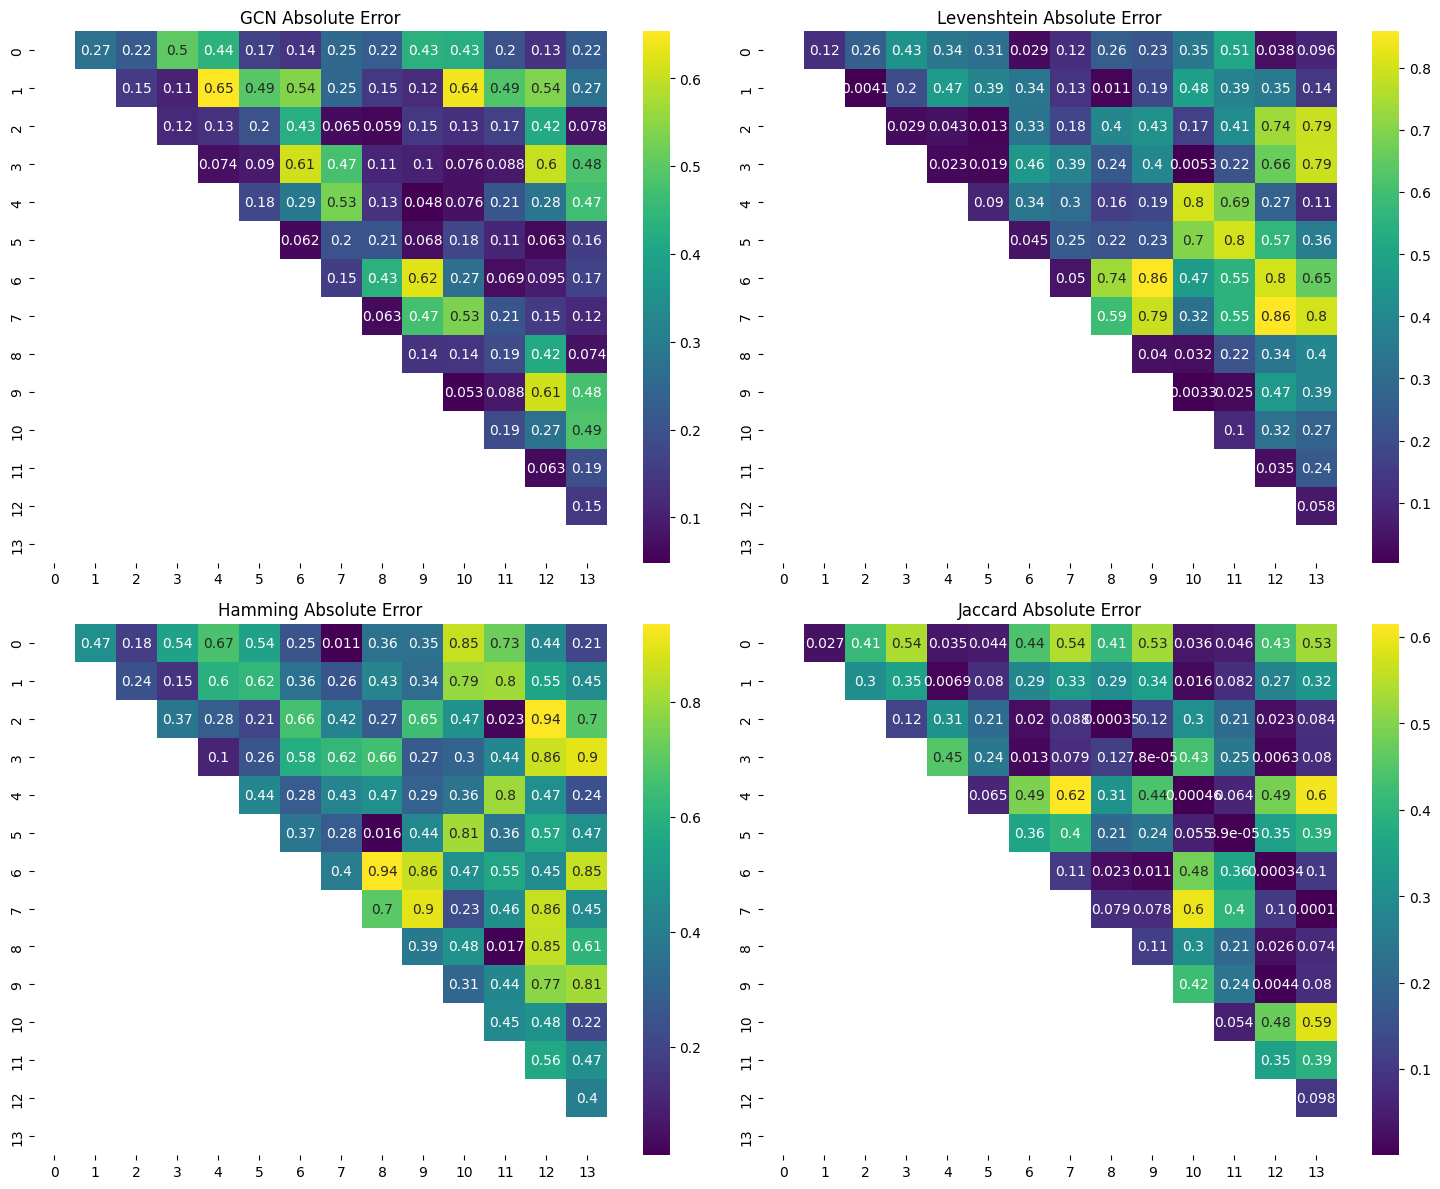

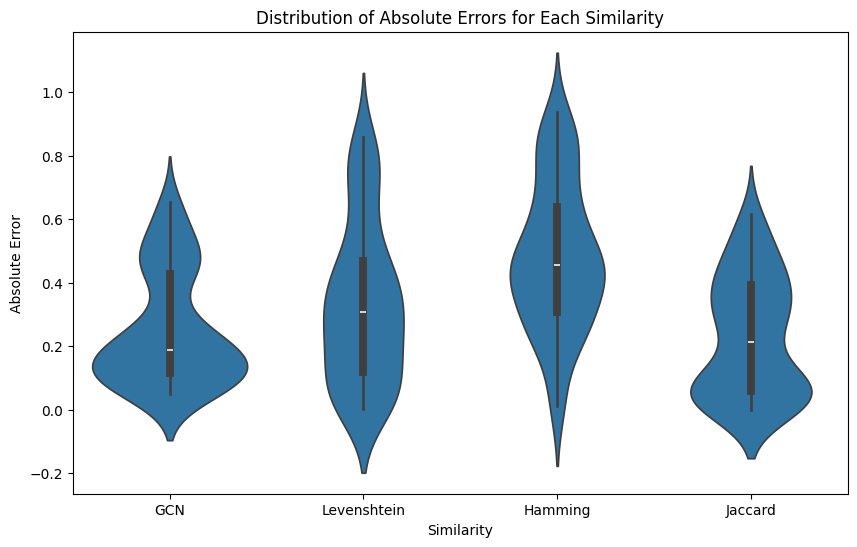

Mean Absolute Errors:
 {'GCN': 0.25109679007513913, 'Levenshtein': 0.3293723001514268, 'Hamming': 0.47978679047426165, 'Jaccard': 0.22761384311909102}
Median Absolute Errors:
 {'GCN': 0.18697509918660693, 'Levenshtein': 0.3077803761066489, 'Hamming': 0.45420385221182025, 'Jaccard': 0.21306644417754195}


In [38]:
import seaborn as sns

# Compute the upper triangular indices
triu_indices = np.triu_indices_from(empirical_similarity, k=1)

# Compute the absolute errors
gcn_error = np.abs(empirical_similarity - embedding_similarity_dtw)
levenshtein_error = np.abs(empirical_similarity - levenshtein_similarity)
hamming_error = np.abs(empirical_similarity - hamming_similarity)
jaccard_error = np.abs(empirical_similarity - jaccard_similarity)

# Mask the lower triangular part
mask = np.tril(np.ones(empirical_similarity.shape, dtype=bool))

# Plot the absolute error as separate matrices
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

sns.heatmap(gcn_error, mask=mask, ax=axes[0, 0], annot=True, cmap='viridis')
axes[0, 0].set_title('GCN Absolute Error')

sns.heatmap(levenshtein_error, mask=mask, ax=axes[0, 1], annot=True, cmap='viridis')
axes[0, 1].set_title('Levenshtein Absolute Error')

sns.heatmap(hamming_error, mask=mask, ax=axes[1, 0], annot=True, cmap='viridis')
axes[1, 0].set_title('Hamming Absolute Error')

sns.heatmap(jaccard_error, mask=mask, ax=axes[1, 1], annot=True, cmap='viridis')
axes[1, 1].set_title('Jaccard Absolute Error')

plt.tight_layout()
plt.show()

# Compute and print the mean and median absolute error for each similarity
mean_absolute_errors = {
    'GCN': np.mean(gcn_error[triu_indices]),
    'Levenshtein': np.mean(levenshtein_error[triu_indices]),
    'Hamming': np.mean(hamming_error[triu_indices]),
    'Jaccard': np.mean(jaccard_error[triu_indices])
}

median_absolute_errors = {
    'GCN': np.median(gcn_error[triu_indices]),
    'Levenshtein': np.median(levenshtein_error[triu_indices]),
    'Hamming': np.median(hamming_error[triu_indices]),
    'Jaccard': np.median(jaccard_error[triu_indices])
}

# Prepare data for violin plot
error_data = pd.DataFrame({
    'GCN': gcn_error[triu_indices],
    'Levenshtein': levenshtein_error[triu_indices],
    'Hamming': hamming_error[triu_indices],
    'Jaccard': jaccard_error[triu_indices]
})

# Melt the DataFrame for seaborn
melted_error_data = error_data.melt(var_name='Similarity', value_name='Absolute Error')

# Plot the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Similarity', y='Absolute Error', data=melted_error_data)
plt.title('Distribution of Absolute Errors for Each Similarity')
plt.show()

print("Mean Absolute Errors:\n", mean_absolute_errors)
print("Median Absolute Errors:\n", median_absolute_errors)